# Denoising Diffusion Models

<details><summary>Setup</summary>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler

dataset: str = "moons"
batch_size: int = 32
total_samples: int = 2_000_000
epochs: int = 10
steps_per_epoch = total_samples // (epochs * batch_size)
total_steps = total_samples // batch_size


def get_data():
    if dataset == "moons":
        X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
    elif dataset == "blobs":
        X = make_blobs(n_samples=1000, centers=6, cluster_std=0.5, random_state=6)[0]
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    X = MinMaxScaler((-1, 1)).fit_transform(X)
    ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
    ds = ds.repeat()
    ds = ds.shuffle(seed=42, buffer_size=1_000)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return X, ds

2022-10-11 02:30:56.082223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


</details>

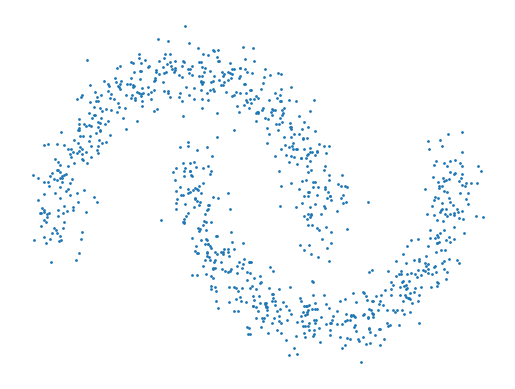

In [2]:
X, ds = get_data()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.axis("off")
plt.show()

In [3]:
import jax
import jax.numpy as jnp
from flax.struct import PyTreeNode


def expand_to(a, b):
    new_shape = a.shape + (1,) * (b.ndim - a.ndim)
    return a.reshape(new_shape)


class GaussianDiffusion(PyTreeNode):
    betas: jnp.ndarray
    alphas: jnp.ndarray
    alpha_bars: jnp.ndarray

    @classmethod
    def create(cls, betas: jnp.ndarray) -> "GaussianDiffusion":
        return cls(
            betas=betas,
            alphas=1.0 - betas,
            alpha_bars=jnp.cumprod(1.0 - betas),
        )


@jax.jit
def forward_diffusion(process: GaussianDiffusion, key, x0, t):
    alpha_bars = expand_to(process.alpha_bars[t], x0)
    noise = jax.random.normal(key, x0.shape)
    xt = jnp.sqrt(alpha_bars) * x0 + jnp.sqrt(1.0 - alpha_bars) * noise
    return xt, noise

In [4]:
def polynomial_schedule(beta_start, beta_end, timesteps, exponent=2.0, **kwargs):
    betas = jnp.linspace(0, 1, timesteps) ** exponent
    return betas * (beta_end - beta_start) + beta_start


def sigmoid_schedule(beta_start, beta_end, timesteps, **kwargs):
    betas = jax.nn.sigmoid(jnp.linspace(-6, 6, timesteps))
    return betas * (beta_end - beta_start) + beta_start


def cosine_schedule(beta_start, beta_end, timesteps, s=0.008, **kwargs):
    x = jnp.linspace(0, timesteps, timesteps + 1)
    ft = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = ft / ft[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = jnp.clip(betas, 0.0001, 0.9999)
    betas = (betas - betas.min()) / (betas.max() - betas.min())
    return betas * (beta_end - beta_start) + beta_start


# TODO: create a plot for each schedule

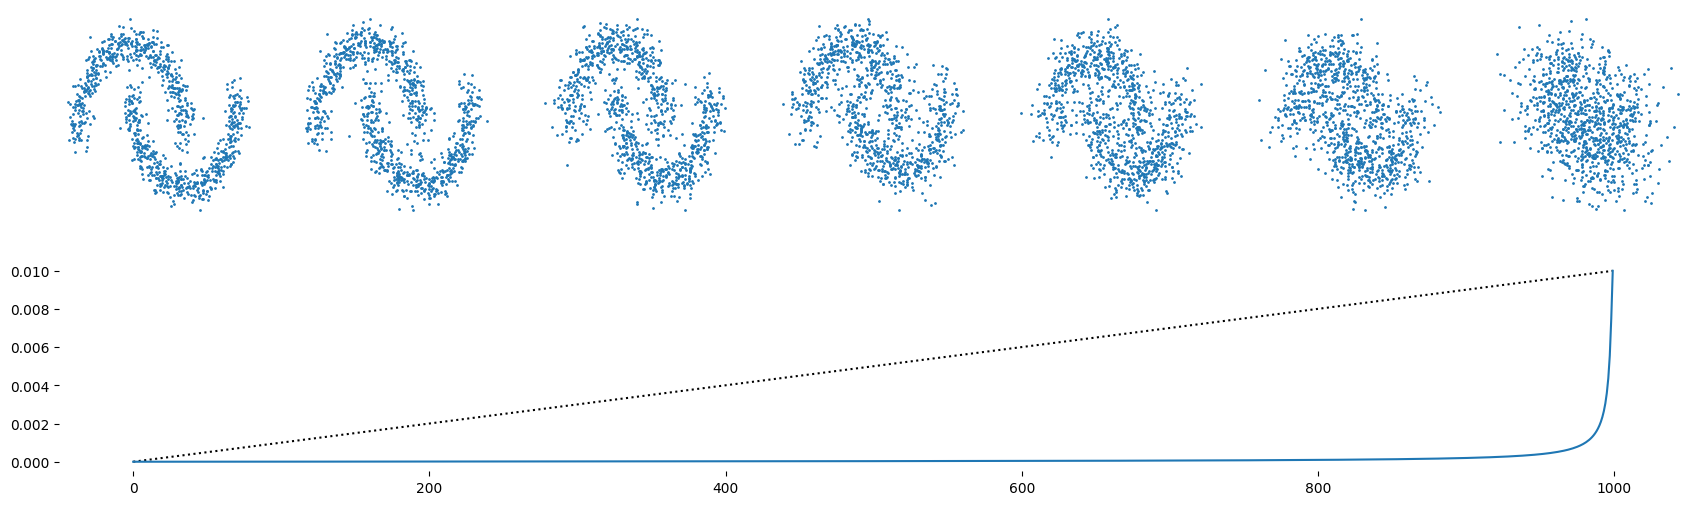

In [5]:
# diffusion
diffusion_schedule: str = "cosine"
diffusion_beta_start: float = 1e-5
diffusion_beta_end: float = 0.01
diffusion_timesteps: int = 1_000

if diffusion_schedule == "polynomial":
    schedule = polynomial_schedule
elif diffusion_schedule == "sigmoid":
    schedule = sigmoid_schedule
elif diffusion_schedule == "cosine":
    schedule = cosine_schedule
else:
    raise ValueError(f"Unknown schedule {diffusion_schedule}")

betas = schedule(diffusion_beta_start, diffusion_beta_end, diffusion_timesteps)
process = GaussianDiffusion.create(betas)
n_rows = 2
n_cols = 7

plt.figure(figsize=(n_cols * 3, n_rows * 3))
for i, ti in enumerate(jnp.linspace(0, diffusion_timesteps, n_cols).astype(int)):
    t = jnp.full((X.shape[0],), ti)
    xt, noise = forward_diffusion(process, jax.random.PRNGKey(ti), X, t)
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(xt[:, 0], xt[:, 1], s=1)
    plt.axis("off")

plt.subplot(2, 1, 2)
linear = polynomial_schedule(
    betas.min(), betas.max(), diffusion_timesteps, exponent=1.0
)
plt.plot(linear, label="linear", color="black", linestyle="dotted")
plt.plot(betas)
for s in ["top", "bottom", "left", "right"]:
    plt.gca().spines[s].set_visible(False)

plt.show()

In [12]:

from base64 import b64encode
from pathlib import Path
from tempfile import TemporaryDirectory

from einop import einop
from IPython.display import HTML, display
from matplotlib import animation
from IPython import get_ipython


def plot_trajectory_2d(
    xs: np.ndarray,
    interval: int = 10,
    repeat_delay: int = 1000,
    step_size: int = 1,
    end_pad: int = 500,
):

    xs = xs[::step_size]

    # replace last sample to create a 'pause' effect
    pad_end = einop(xs[-1], "... -> batch ...", batch=end_pad)
    xs = np.concatenate([xs, pad_end], axis=0)

    N = len(xs)

    fig = plt.figure()
    plt.axis("off")
    scatter = plt.scatter(xs[0][:, 0], xs[0][:, 1], s=1)

    def animate(i):
        scatter.set_offsets(xs[i])
        return [scatter]

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=lambda: animate(0),
        frames=np.linspace(0, N - 1, N, dtype=int),
        interval=interval,
        repeat_delay=repeat_delay,
        blit=True,
    )

    if get_ipython():
        with TemporaryDirectory() as tmpdir:
            img_name = Path(tmpdir) / f"diffusion.gif"
            anim.save(str(img_name), writer="pillow", fps=60)
            image_bytes = b64encode(img_name.read_bytes()).decode("utf-8")

        display(HTML(f"""<img src='data:image/gif;base64,{image_bytes}'>"""))
    else:
        pass

    return anim


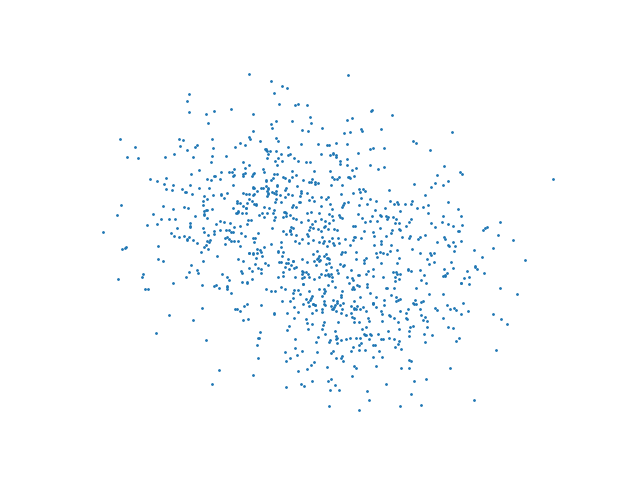

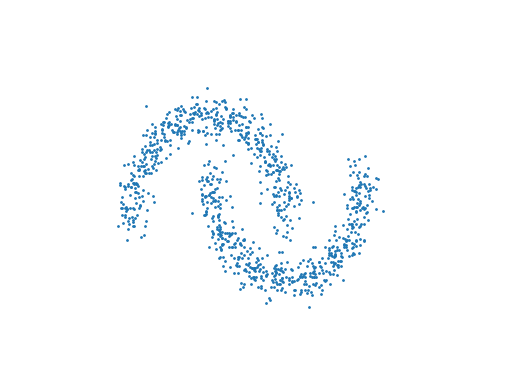

In [16]:
ts = jnp.arange(diffusion_timesteps)[::-1]
xs = einop(X, "... -> t ...", t=diffusion_timesteps)
xs, noise = forward_diffusion(process, jax.random.PRNGKey(0), xs, ts)


plot_trajectory_2d(xs, step_size=10)

In [8]:
import flax.linen as nn

class SinusoidalPosEmb(nn.Module):
    dim: int

    def __call__(self, t):
        half_dim = self.dim // 2
        mul = jnp.log(10000) / (half_dim - 1)
        emb = jnp.exp(-mul * jnp.arange(half_dim))
        emb = t[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb


class TimeConditionedDense(nn.Module):
    units: int
    emb_dim: int

    @nn.compact
    def __call__(self, x, t):
        t_embeddings = SinusoidalPosEmb(self.emb_dim)(t)
        x = jnp.concatenate([x, t_embeddings], axis=-1)
        x = nn.Dense(self.units)(x)
        return x


class Denoiser(nn.Module):
    units: int = 128
    emb_dim: int = 32

    @nn.compact
    def __call__(self, x, t):
        inputs_units = x.shape[-1]
        dense = lambda units: TimeConditionedDense(units, self.emb_dim)
        x = nn.relu(dense(self.units)(x, t))
        x = nn.relu(dense(self.units)(x, t)) + x
        x = nn.relu(dense(self.units)(x, t)) + x
        x = dense(inputs_units)(x, t)
        return x

In [9]:
from clu.metrics import Average, Collection
from flax import struct


@struct.dataclass
class Metrics(Collection):
    loss: Average.from_output("loss")

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

In [10]:
import optax
from flax.training.train_state import TrainState


# model
model_units: int = 128
model_emb_dim: int = 32
# optimizer
optimizer_lr_start: float = 1e-3
optimizer_drop_1_mult: float = 0.1
optimizer_drop_2_mult: float = 0.1

module = Denoiser(units=model_units, emb_dim=model_emb_dim)
variables = module.init(jax.random.PRNGKey(42), X[:1], jnp.array([0]))
tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(
        optax.piecewise_constant_schedule(
            optimizer_lr_start,
            {
                int(total_steps * 1 / 3): optimizer_drop_1_mult,
                int(total_steps * 2 / 3): optimizer_drop_2_mult,
            },
        )
    ),
)
state: TrainState = TrainState.create(
    apply_fn=module.apply, params=variables["params"], tx=tx
)
metrics = Metrics.empty()

print(module.tabulate(jax.random.PRNGKey(42), X[:1], jnp.array([0]), depth=1))

                       Denoiser Summary                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path                   ┃ outputs        ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs                 │ - float64[1,2] │                   │
│                        │ - int32[1]     │                   │
├────────────────────────┼────────────────┼───────────────────┤
│ TimeConditionedDense_0 │ float32[1,128] │ 4,480 (17.9 KB)   │
├────────────────────────┼────────────────┼───────────────────┤
│ TimeConditionedDense_1 │ float32[1,128] │ 20,608 (82.4 KB)  │
├────────────────────────┼────────────────┼───────────────────┤
│ TimeConditionedDense_2 │ float32[1,128] │ 20,608 (82.4 KB)  │
├────────────────────────┼────────────────┼───────────────────┤
│ TimeConditionedDense_3 │ float32[1,2]   │ 322 (1.3 KB)      │
├────────────────────────┼────────────────┼───────────────────┤
│ Denoiser               │ float32[1,2]   │                   │
├────────────────────────┼────────────────┼───────────────────┤
│                        │          Total │ 46,018 (184.1 KB) │
└────────────────────────┴────────────────┴───────────────────┘
                                                               
              Total Parameters: 46,018 (184.1 KB)              

In [11]:
from functools import partial

from einop import einop


@jax.jit
def reverse_diffusion(process: GaussianDiffusion, key, x, noise_hat, t):
    betas = expand_to(process.betas[t], x)
    alphas = expand_to(process.alphas[t], x)
    alpha_bars = expand_to(process.alpha_bars[t], x)

    z = jnp.where(
        expand_to(t, x) > 0, jax.random.normal(key, x.shape), jnp.zeros_like(x)
    )
    noise_scaled = betas / jnp.sqrt(1.0 - alpha_bars) * noise_hat
    x = (x - noise_scaled) / jnp.sqrt(alphas) + jnp.sqrt(betas) * z
    return x


@partial(jax.jit, static_argnames=["return_all"])
def sample(key, x0, ts, params, process, *, return_all=True):
    print("compiling 'sample' ...")
    keys = jax.random.split(key, len(ts))
    ts = einop(ts, "t -> t b", b=x0.shape[0])

    def scan_fn(x, inputs):
        t, key = inputs
        noise_hat = module.apply({"params": params}, x, t)
        x = reverse_diffusion(process, key, x, noise_hat, t)
        out = x if return_all else None
        return x, out

    x, xs = jax.lax.scan(scan_fn, x0, (ts, keys))
    return xs if return_all else x

In [12]:
loss_type: str = "mae"

if loss_type == "mse":
    loss_metric = lambda a, b: jnp.mean((a - b) ** 2)
elif loss_type == "mae":
    loss_metric = lambda a, b: jnp.mean(jnp.abs(a - b))
else:
    raise ValueError(f"Unknown loss type {loss_type}")


def loss_fn(params, xt, t, noise):
    noise_hat = state.apply_fn({"params": params}, xt, t)
    return loss_metric(noise, noise_hat)


@jax.jit
def train_step(key, x, state: TrainState, metrics: Metrics, process: GaussianDiffusion):
    print("compiling 'train_step' ...")
    key_t, key_diffusion, key = jax.random.split(key, 3)
    t = jax.random.uniform(
        key_t, (x.shape[0],), minval=0, maxval=diffusion_timesteps - 1
    ).astype(jnp.int32)
    xt, noise = forward_diffusion(process, key_diffusion, x, t)
    loss, grads = jax.value_and_grad(loss_fn)(state.params, xt, t, noise)
    state = state.apply_gradients(grads=grads)
    metrics = metrics.update(loss=loss)
    logs = metrics.compute()
    return logs, key, state, metrics

In [ ]:
import numpy as np
from tqdm import tqdm

eval_every: int = 2000
log_every: int = 200

key = jax.random.PRNGKey(42)
axs_diffusion = None
axs_samples = None
ds_iterator = ds.as_numpy_iterator()

step = 0
history = []

In [ ]:
for step in tqdm(range(step, total_steps), total=total_steps, unit="step"):
    logs = {}

    if step % steps_per_epoch == 0:
        # --------------------
        # visualize progress
        # --------------------
        n_cols = 7
        n_samples = 1000
        viz_key = jax.random.PRNGKey(1)
        x = jax.random.normal(viz_key, (n_samples, *X.shape[1:]))

        ts = np.arange(diffusion_timesteps)[::-1]
        xs = np.asarray(sample(viz_key, x, ts, state.params, process, return_all=True))
        if axs_diffusion is None or get_ipython():
            _, axs_diffusion = plt.subplots(1, n_cols, figsize=(n_cols * 3, 3))

        ts = jnp.linspace(0, diffusion_timesteps - 1, n_cols).astype(int)
        for i, ti in enumerate(ts):
            axs_diffusion[i].clear()
            axs_diffusion[i].scatter(xs[ti, :, 0], xs[ti, :, 1], s=1)
            axs_diffusion[i].axis("off")
        plt.show()

    if step % log_every == 0 and logs != {}:
        log_metrics(logs, step, do_print=False)
        history.append(logs)
        metrics = metrics.empty()

    # --------------------
    # trainig step
    # --------------------
    x = ds_iterator.next()
    logs, key, state, metrics = train_step(key, x, state, metrics, process)
    logs["step"] = step

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
steps = np.array([h["step"] for h in history])
plt.plot(steps, [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

In [ ]:
n_samples = 1000
viz_key = jax.random.PRNGKey(1)
x = jax.random.normal(viz_key, (n_samples, *X.shape[1:]))
ts = np.arange(diffusion_timesteps)[::-1]
x = np.asarray(sample(viz_key, x, ts, state.params, process, return_all=False))

# plot x and X side by side
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x[:, 0], x[:, 1], s=1)
axs[0].axis("off")
axs[0].set_title("model")
axs[1].scatter(X[:, 0], X[:, 1], s=1)
axs[1].axis("off")
axs[1].set_title("data")
plt.show()